<a href="https://colab.research.google.com/github/aidegare/bigdata/blob/main/GW_DA_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
!{sys.executable} -m pip install pycbc ligo-common --no-cache-dir 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from __future__ import division

import numpy as np
import lal
import lalsimulation

import matplotlib.pyplot as plt
from scipy import interpolate
from numpy import pi, arange
from scipy import constants
from pycbc.conversions import *
from astropy import cosmology
from pycbc import waveform

from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.waveform import get_fd_waveform
from pycbc.psd import welch, interpolate
from pycbc.catalog import Merger
import pylab
from pycbc.types import  FrequencySeries, TimeSeries

from scipy import interpolate

from pycbc import frame
import pycbc
from pycbc.filter import resample_to_delta_t, highpass, matched_filter
import matplotlib.mlab as mlab
from scipy.stats import norm 
from pycbc.detector import Detector
from scipy.interpolate import interp1d



In [ ]:
# You can completely ignore this, it was completely for my own fun while coding 
# Announcing the code starts running this way was the best way for me to get motivated
from IPython.display import Audio
wn = Audio('/content/drive/MyDrive/okeee_lets_go.mp3', autoplay=True)
display(wn)

#Exercise 1

### 1st part (downsample to 2048Hz)

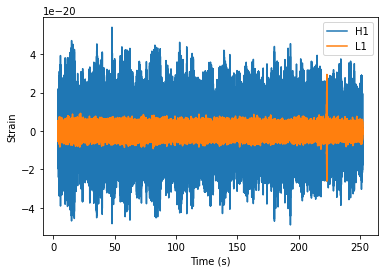

In [ ]:
import pylab
from pycbc.filter import highpass
from pycbc.catalog import Merger
from pycbc.frame import read_frame

d = np.load('/content/drive/MyDrive/GW_noisedata-2.npy') #name of the data file noise_ts_4096Hz.npy
dt = d[:, 0]
data_H1 = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0]) #this is to convert data into GW timeSeries
data_L1 = pycbc.types.TimeSeries(d[:, 2], delta_t = dt[1]- dt[0]) #this is to convert data into GW timeSeries

# merger = Merger("GW170817")
strain, stilde = {}, {}
strain['H1'] = resample_to_delta_t(highpass(data_H1, 15.0), 1.0/2048)
strain['L1'] = resample_to_delta_t(highpass(data_L1, 15.0), 1.0/2048)

strain['H1'] = strain['H1'].crop(4, 4)
strain['L1'] = strain['L1'].crop(4, 4)

stilde['H1'] = strain['H1'].to_frequencyseries()
stilde['L1'] = strain['L1'].to_frequencyseries()

#print (strain.delta_t)
pylab.plot(strain['H1'].sample_times, strain['H1'], label= 'H1')
pylab.plot(strain['L1'].sample_times, strain['L1'], label= 'L1')
pylab.legend()
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.show()

## 2nd part (match the filter between given data and the waveform)

### Plot the Power Spectral density from the

0.004032258064516129

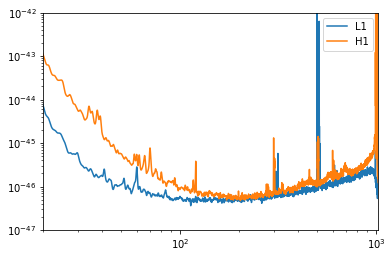

In [ ]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
psds = {}
for ifo in ['L1','H1']:
# Calculating a power spectal density from the data using 3s segments for a welch method, and then interpolating it to the desired frequency
  psds[ifo] = interpolate(strain[ifo].psd(3), stilde[ifo].delta_f)
# Tapering the 3s data snippets for the welch method with the Hann method
  psds[ifo] = inverse_spectrum_truncation(psds[ifo],int(3*strain[ifo].sample_rate),low_frequency_cutoff=15.0,trunc_method='hann')
  pylab.loglog(psds[ifo].sample_frequencies, psds[ifo],label=ifo)
  pylab.xlim(20,1024)
  pylab.ylim(1e-47,1e-42)
pylab.legend()
psds[ifo].delta_f

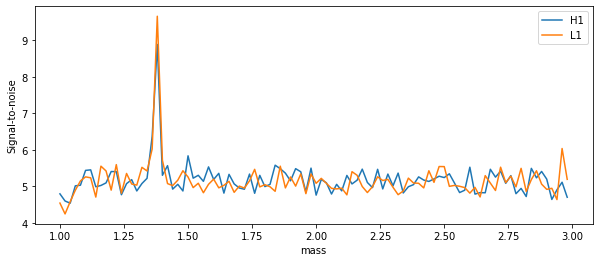

In [ ]:
from numpy import arange
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower


Snr_list = []
snrs = {}

masses = arange(1,3,0.02)

# Looping through masses from 1 to 3 solar masses with steps of 0.02 in both parts of the data
for ifo in ['H1', 'L1']:
  for m in masses:

    # Generating a waveform with binary masses m 
    hp, hc = get_td_waveform(approximant="TaylorT2",
                            mass1=m,
                            mass2=m,
                            delta_t=strain[ifo].delta_t,
                            f_lower=20)
    
    hp.resize(len(strain[ifo]))
    # Creating a template from the generated waveform 
    template = hp.cyclic_time_shift(hp.start_time)
    # Estimating the SNR between the template and the data
    snr = matched_filter(template, strain[ifo],
                          psd=psds[ifo], 
                          low_frequency_cutoff=20)
    snr1 = snr.crop(4 + 4, 4)
    # Saving the information into a plotable format 
    snrs[ifo] = Snr_list.append(max(abs(snr1)))
  snrs[ifo] = Snr_list
  Snr_list = []

pylab.figure(figsize=[10, 4])
pylab.plot(masses, snrs['H1'], label = 'H1')
pylab.plot(masses, snrs['L1'], label = 'L1')
pylab.legend()
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

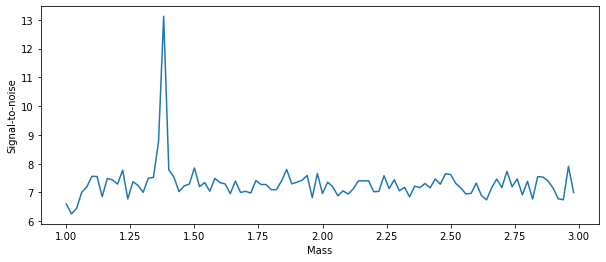

The best m1 = m2 found is 1.38 solar masses (detector frame)


In [ ]:
#Combining the SNR from both L1 and H1 in one graph
nsnr = (np.array(snrs['H1'])**2 + np.array(snrs['L1'])**2)**0.5
ii = np.where(nsnr == max(nsnr))
pylab.figure(figsize=[10, 4])
pylab.plot(masses, nsnr)

pylab.ylabel('Signal-to-noise')
pylab.xlabel('Mass')
pylab.show()

print("The best m1 = m2 found is %2.2f solar masses (detector frame)" % masses[ii])

### Creating the template

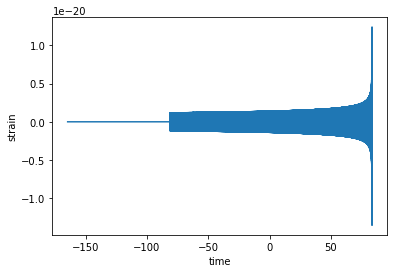

In [ ]:
# We assume equal masses 
m = 1.38 # solar masses
conditioned = strain['H1']
hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

# We will resize the vector to match our data
hp.resize(len(conditioned))

# We need to shift the data if we want the merger to be around the first bin of the data.
template = hp.cyclic_time_shift(hp.start_time)
pylab.plot(hp.sample_times, template)
pylab.xlabel('time')
pylab.ylabel('strain')
pylab.show()

And fitting it onto the data

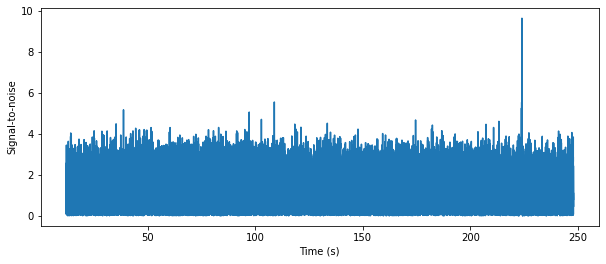

We found a signal at 224.02490234375s with SNR 9.655465807079086


In [ ]:
from pycbc.filter import matched_filter
import numpy

for ifo in ['H1','L1']:
  conditioned = strain[ifo]
  snr = matched_filter(template, conditioned, psd=psds[ifo] , low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seonds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for 
# so short a template). A longer signal such as from a BNS, would 
# require much more padding at the beginning of the vector.
  snr = snr.crop(4 + 4, 4)

# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))


Pretty good signal found at 224 seconds with an SNR a bit over 9

### Q-transform plotting

In [ ]:
from pycbc.filter import sigma

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psds[ifo], low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

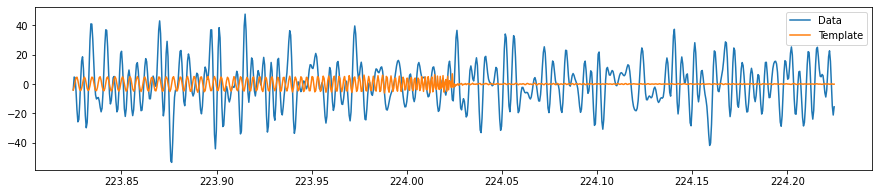

In [ ]:
# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)

# Select the time around the peak of the snr
white_data = white_data.time_slice(snr.sample_times[peak]-.2, snr.sample_times[peak]+.2)
white_template = white_template.time_slice(snr.sample_times[peak]-.2, snr.sample_times[peak]+.2)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

We can't seem to fit the template properly to the data, but we can still try to make a plot out of it.

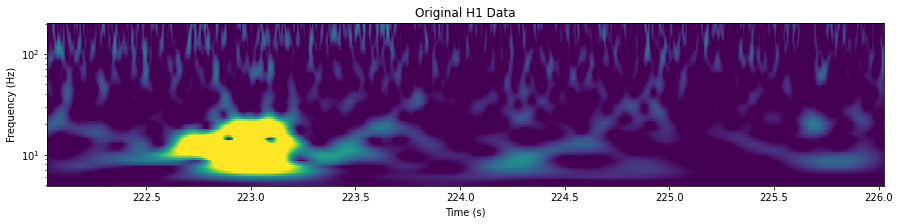

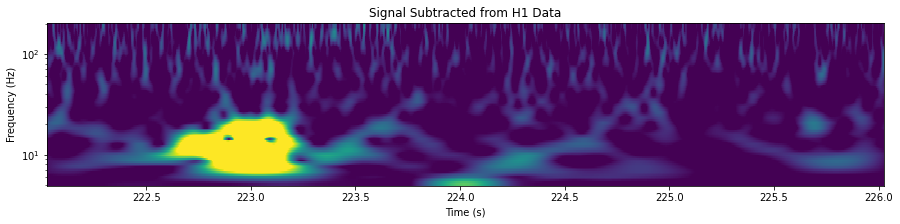

In [ ]:
subtracted = conditioned - aligned

# Plot the original data and the subtracted signal data

for data, title in [(conditioned, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,logfsteps=100,qrange=(8, 8),frange=(5, 200))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.yscale('log')
    pylab.xlim(snr.sample_times[peak] - 2, snr.sample_times[peak] + 2)
    pylab.show()



## 3rd part)

Calculating the match between h* adn h_t and plot against the masses

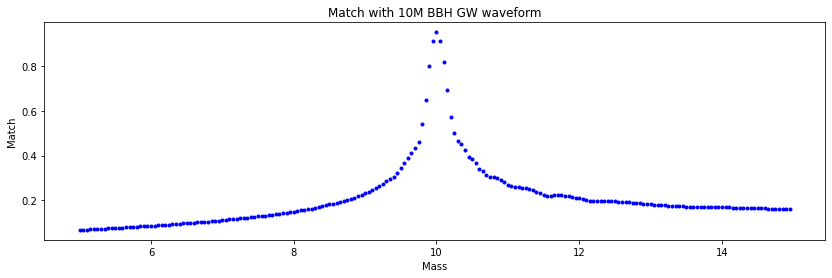

In [ ]:
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower

f_low = 30
sample_rate = 4096
masses = arange(5,15,0.05)
matches = {}

for mass in masses:
  # Generate the two waveforms to compare
  hp, hc = get_td_waveform(approximant="EOBNRv2",
                          mass1=10,
                          mass2=10,
                          f_lower=f_low,
                          delta_t=1.0/sample_rate)

  sp, sc = get_td_waveform(approximant="TaylorT4",
                          mass1=mass,
                          mass2=mass,
                          f_lower=f_low,
                          delta_t=1.0/sample_rate)

  # Resize the waveforms to the same length
  tlen = max(len(sp), len(hp))
  sp.resize(tlen)
  hp.resize(tlen)

  # Generate the aLIGO ZDHP PSD
  delta_f = 1.0 / sp.duration
  flen = tlen//2 + 1
  psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

  # Note: This takes a while the first time as an FFT plan is generated
  # subsequent calls are much faster.
  m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low)
  matches[mass]=m

pylab.figure(figsize=[14, 4])
pylab.title("Match with 10M BBH GW waveform")
pylab.ylabel('Match')
pylab.xlabel('Mass')
pylab.plot(*zip(*matches.items()),'b.')
pylab.show()

# Exercise 2

### Plot the PSD

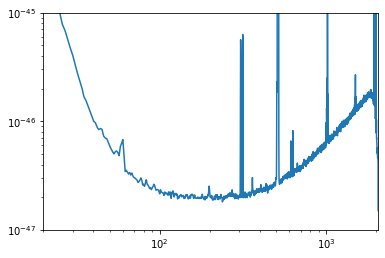

In [ ]:
from scipy import interpolate
from pycbc.psd import welch, interpolate, inverse_spectrum_truncation
d = np.load('/content/drive/MyDrive/noise_ts_4096Hz.npy') #name of the data file noise_ts_4096Hz.npy
dt = d[:, 0]
data = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0]) #this is to convert data into GW timeSeries

# After putting the data as a timeSeries, we can plot it pewer spectral density
psds = interpolate(welch(data), 1.0 / data.duration)

pylab.loglog(psds.sample_frequencies, psds)
pylab.xlim(20, max(psds.sample_frequencies))
pylab.ylim(1e-47, 1e-45)
pylab.show()

### Search for the maximum SNR

We did not detect a gravitational wave, this is the max SNR: 6.545255065945568


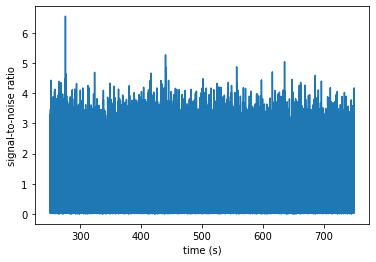

In [ ]:
stilde = data.to_frequencyseries()
masses = arange(5,10,0.1)
snrp = 0
maxsnr = 0
flow = 30
# Looping through masses in both parts of the data

for m in masses:

  # Generating a waveform with binary masses m 
  hp, hc = get_fd_waveform(approximant="TaylorF2",
                            mass1=m,
                            mass2=m,
                            delta_f=stilde.delta_f,
                            f_lower=20)
    
  hp.resize(len(stilde))
  # Creating a template from the generated waveform 
  template = hp.cyclic_time_shift(hp.start_time)
  # Estimating the SNR between the template and the data
  snr = matched_filter(template, stilde,
                          psd=psds, 
                          low_frequency_cutoff=flow)
  snr = snr[len(snr) // 4: len(snr) * 3 // 4]
  # get the biggest snr
  if max(abs(snr)) > maxsnr:
    maxsnr = max(abs(snr))
    snrp = snr

#check if gravitational wave present
if maxsnr < 8:
  print ("We did not detect a gravitational wave, this is the max SNR: {}".format(maxsnr))
else:
  print("We did detect a gravitational wave with SNR: {}".format(maxsnr))
  

pylab.plot(snrp.sample_times, abs(snrp))
pylab.ylabel('signal-to-noise ratio')
pylab.xlabel('time (s)')
pylab.show()

No SNR ratio higher than 8 has been found, so we can assume that this dataset does not have gravitational waves.

### Whitening the data

0.0014166022882674619 44.72975447257879


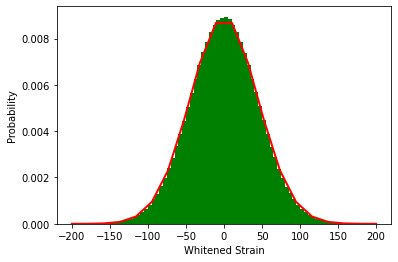

In [ ]:
delta_t = 1.0 / 4096
tsamples = int(128 / delta_t)

# We can estimate the PSD first
# We'll choose 4 seconds PSD samples that are overlapped 50 %
seg_len = int(4 / delta_t)
seg_stride = int(seg_len / 2)
psds = pycbc.psd.welch(data,
                      seg_len=seg_len,
                      seg_stride=seg_stride)
     

# Whiten both the template and the data
psd = interpolate(welch(data), 1.0 / data.duration)


white_data = (data.to_frequencyseries() / psd**0.5).to_timeseries()

     

# Whiten data
from scipy.stats import norm
import matplotlib.mlab as mlab
  
ran = range(-200,200,5)

# Then plot the histogram
white_data = white_data.crop(4,4)
plt.hist(white_data, ran, color = "green", density=True)

# Plotting best fit
(mu, sigma) = norm.fit(white_data)
x = np.linspace(-200,200, 20)
plt.plot(x, norm.pdf(x, mu, sigma), linewidth = 2, color = "red")
plt.xlabel("Whitened Strain")
plt.ylabel("Probability")
print(mu, sigma)
plt.show() 

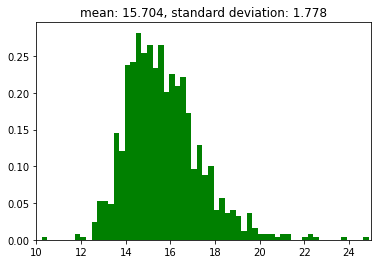

In [ ]:
from statistics import mean, stdev
max = 1000
hp, hc = get_fd_waveform(approximant="TaylorF2",   
                         mass1=3,                  
                         mass2=3,   
                         delta_f = 1.0/(200),              
                         #delta_f=1.0/(200.0) ,     
                         distance = 500,           
                         f_lower=20.0, f_final = 2048.0)    #Luminosity distance = 500 Mpc


# We need to slice the data in chunks 
slice_data = int(len(data)/max)

SNRlist = []

# And loop through all of them while plotting their power spectral density
for i in range(max):
  data_chunk = data[i*slice_data : (i+1)*slice_data]

  psds = pycbc.psd.interpolate(pycbc.psd.welch(data_chunk), hp.delta_f)

  optSNR = (pycbc.filter.sigmasq(hp, psds))**0.5

  SNRlist.append(optSNR)

mu, sigma = mean(SNRlist), stdev(SNRlist)

plt.title('mean: {:.3f}, standard deviation: {:.3f}'.format(mu, sigma))
plt.hist(SNRlist, 100, density = True, color = 'green')
plt.xlim(10,25)
plt.show()

We can see that it's clearly a non-stationary Gaussian distribution, stating that our assumption was false.

# Exercise 3

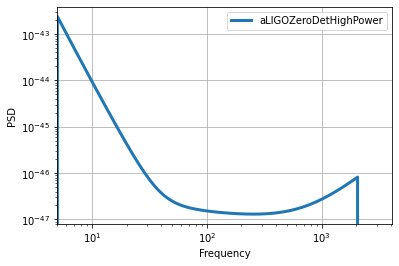

In [ ]:
import pycbc.noise
import pycbc.psd
import pylab
from scipy import interpolate
from pycbc.psd import welch, interpolate, inverse_spectrum_truncation

# generate some colored gaussian noise
flow = 5.0
delta_f = 1.0 / 16
flen = int(2048.0 / (delta_f)) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)
pylab.loglog(psd.sample_frequencies - 1 , psd, linewidth=3, label='aLIGOZeroDetHighPower')

pylab.xlim(xmin=flow, xmax=4096)
pylab.xlabel('Frequency')
pylab.ylabel('PSD')
pylab.legend()
pylab.grid()
pylab.show()


In [ ]:
from pycbc.filter import sigmasq

flow = 4.0 #Hz

interval = 1
masses = arange(5,550,interval)

a = []
b = []

for m in masses:
  hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                              mass1=m, mass2=m,
                              f_lower=flow, 
                              delta_f=delta_f,
                              distance = 1000)

  SNR = (pycbc.filter.sigmasq(hp, psd))**0.5

# using previous threshold to check for gravitational waves
  if SNR > 8: 
    a.append(SNR/8)
    b.append(m)

pylab.plot(b, a)
pylab.ylabel('horizontal distance')
pylab.xlabel('Total mass')
pylab.show()

ValueError: ignored

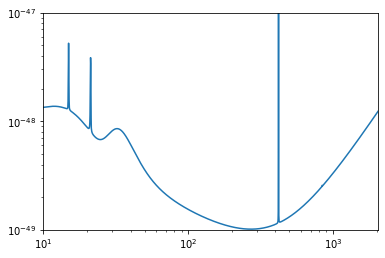

In [ ]:
import pycbc.psd
import numpy as np
flow = 4.0   # set up the lower cut off frequency
delta_f = 1.0 / 16
flen = int(2048.0/ (delta_f)) + 1
psd = pycbc.psd.EinsteinTelescopeP1600143(flen, delta_f, flow)
psd.data[:int(flow/delta_f)] = np.inf  #set the value outside the frequency range to infinity
psd.data[-1] = np.inf

pylab.loglog(psd.sample_frequencies, psd)
pylab.xlim(10,2048)
pylab.ylim(1e-49, 1e-47)
pylab.show()

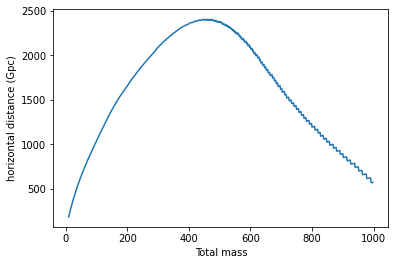

In [ ]:
flow = 4.0 #Hz

masses = arange(5,500,1)

yplot = []
xplot = []

for m in masses:
  hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                              mass1=m, mass2=m,
                              f_lower=flow, 
                              delta_f=delta_f,
                              distance = 100)

  SNR = (pycbc.filter.sigmasq(hp, psd))**0.5
  
  yplot.append(SNR/8)
  xplot.append(m*2)

pylab.plot(xplot, yplot)
pylab.ylabel('horizontal distance (Gpc)')
pylab.xlabel('Total mass')
pylab.show()